Define a classe correta com base nos parâmetros tipo e categoria presentes em cada questão do dataset Chave

In [1]:
def correct_class(t, c):
    if c == 'COUNT':
        return 'MEASURE'
    if c == 'D' or c == 'DEFINITION':
        return 'DEFINITION'
    if c == 'F' or c == 'FACTOID':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'L' or c == 'LIST':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'LOCATION':
        return 'LOCATION'
    if c == 'MEASURE':
        return 'MEASURE'
    if c == 'OBJECT':
        return 'DEFINITION'
    if c == 'ORGANIZATION':
        return 'ORGANIZATION'
    if c == 'OTHER' and (t == 'FACTOID' or t == 'LIST'):
        return 'OTHER'
    if c == 'OTHER' and not (t == 'FACTOID' or t == 'LIST'):
        return t
    if c == 'PERSON' and t == 'DEFINITION':
        return 'DEFINITION'
    if c == 'PERSON' and not t == 'DEFINITION':
        return 'PERSON'
    if c == 'TIME':
        return 'TIME'
    return c

Realiza o pré-processamento no texto da questão

In [2]:
def pre_processing(text):
    if text is None:
        return None
    ret = text.replace('\n', '').replace('\r', '')
    ret = ret.replace('?', '').replace('.', '').replace(',', '')
    ret = ret.replace(':', '').replace(';', '')
    ret = ret.replace('\'', '').replace('\"', '')
    ret = ret.replace(u'«', '').replace(u'»', '')
    ret = ret.lower()
    
    return ret

Buscar dados do dataset Chave

In [22]:
import xml.etree.ElementTree as et
import qa_system
import re
import numpy as np
import random
import nltk

random.seed(1)

path_questions = "data/questions.xml"
STOPWORDS = False

if STOPWORDS:
    stopwords = nltk.corpus.stopwords.words('portuguese')
m_x, a_x = 0, 0
X, y = [], []
tree = et.parse(open(path_questions, 'r'))
for question in tree.getroot():
    
    t = question.attrib['tipo']
    c = question.attrib['categoria']
    clss = correct_class(t, c)
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    if clss == 'OTHER':
        continue
    
    for t in question:
        if t.tag == 'texto':
            text = pre_processing(t.text)
            if text is not None:
                if type(text) == type(''): text = text.decode('utf-8')
                text = nltk.word_tokenize(text)
                if STOPWORDS:
                    n_text = []
                    for te in text:
                        if te not in stopwords:
                            n_text.append(te)
                    text = n_text
                if len(text) > m_x:
                    m_x = len(text)
                    print text
                a_x += len(text)
                X.append(text)
                y.append(clss)
                break
                
print 'X:',len(X),' y:',len(y)
a = zip(X, y)
random.shuffle(a)
X, y = zip(*a)
X, y = np.array(X), np.array(y)
print 'max ', m_x
print 'av ', a_x/float(len(X))


[u'em', u'que', u'ano', u'foi', u'atribu\xeddo', u'o', u'pr\xe9mio', u'nobel', u'a', u'thomas', u'mann']
[u'que', u'na\xe7\xe3o', u'\xe9', u'a', u'principal', u'fornecedora', u'de', u'armas', u'a', u'pa\xedses', u'do', u'terceiro', u'mundo']
[u'com', u'que', u'idade', u'\xe9', u'que', u'michael', u'jackson', u'come\xe7ou', u'a', u'cantar', u'no', u'grupo', u'jackson', u'five']
[u'quem', u'recebeu', u'o', u'pr\xe9mio', u'pr\xedncipe', u'das', u'ast\xfarias', u'de', u'investiga\xe7\xe3o', u'cientifica', u'e', u'tecnol\xf3gica', u'pelo', u'desenvolvimento', u'da', u'primeira', u'vacina', u'sint\xe9tica', u'contra', u'a', u'mal\xe1ria']
[u'quem', u'gabou', u'indur\xe1in', u'pela', u'sua', u'capacidade', u'de', u'sacrif\xedcio', u'classe', u'e', u'esp\xedrito', u'saud\xe1vel', u'de', u'competi\xe7\xe3o', u'quando', u'ele', u'ganhou', u'a', u'volta', u'\xe0', u'fran\xe7a', u'pela', u'quarta', u'vez']
[u'quem', u'continuou', u'a', u'receber', u'sangue', u'contaminado', u'seis', u'meses', u'ap

Modelos de EmbeddingVectorizer

In [23]:
import numpy as np
from collections import Counter, defaultdict


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class SequenceEmbeddingVectorizer(object):
    def __init__(self, word2vec, tfidf=False):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
        self.word2weight = None
        self.tfidf = tfidf
    
    def fit(self, X, y):
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            vector = np.array([])
            maxWords = 32
            count = 0
            for word in sentence:
                if count < maxWords:
                    if word in self.word2vec:
                        count += 1
                        if self.tfidf:
                            vector = np.concatenate([vector, self.word2vec[word] * self.word2weight[word]])
                        else:
                            vector = np.concatenate([vector, self.word2vec[word]])
            for i in range(maxWords-count):
                vector = np.concatenate([vector, np.zeros(self.dim)])
            ret.append(vector)
        ret = np.array(ret)
        return ret
    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec, LOWER=False):
        self.word2vec = word2vec
        self.word2weight = None
        self.lower = LOWER
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)

def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)

Carregar Modelos

In [5]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec

cbow_w2v_50 = 'data/word_embedding/cbow_s50_w2v.txt'
cbow_w2v_100 = 'data/word_embedding/cbow_s100_w2v.txt'
cbow_w2v_300 = 'data/word_embedding/cbow_s300_w2v.txt'
cbow_w2v_600 = 'data/word_embedding/cbow_s600_w2v.txt'

skip_w2v_300 = 'data/word_embedding/skip_s300_w2v.txt'

Carregar modelos Word2Vec em Português 

In [ ]:
mw2v_50 = KeyedVectors.load_word2vec_format(cbow_w2v_50, unicode_errors="ignore")
w2v_50 = {w: vec for w, vec in zip(mw2v_50.index2word, mw2v_50.syn0)}

In [ ]:
mw2v_100 = KeyedVectors.load_word2vec_format(cbow_w2v_100, unicode_errors="ignore")
w2v_100 = {w: vec for w, vec in zip(mw2v_100.index2word, mw2v_100.syn0)}

In [6]:
mw2v_300 = KeyedVectors.load_word2vec_format(cbow_w2v_300, unicode_errors="ignore")
w2v_300 = {w: vec for w, vec in zip(mw2v_300.index2word, mw2v_300.syn0)}

In [ ]:
mw2v_600 = KeyedVectors.load_word2vec_format(cbow_w2v_600, unicode_errors="ignore")
w2v_600 = {w: vec for w, vec in zip(mw2v_600.index2word, mw2v_600.syn0)}

In [ ]:
mw2v_300_skp = KeyedVectors.load_word2vec_format(skip_w2v_300, unicode_errors="ignore")
w2v_300_skp = {w: vec for w, vec in zip(mw2v_300_skp.index2word, mw2v_300_skp.syn0)}

Definindo os modelos de teste

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC

/home/eduardo/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
all_results = {}
all_models = {}

In [9]:
def test_model(vector_model, classifer, cv=5):
    model = Pipeline([("vector_model", vector_model), ("classifer", classifer)])
    return cross_val_score(model, X, y, cv=cv).mean(), model

Naive Bayes

In [ ]:
all_results["NB mult"], all_models["NB mult"] = test_model(count_vectorizer(), MultinomialNB())
all_results["NB mult tfidf"], all_models["NB mult tfidf"] = test_model(tfidf_vectorizer(), MultinomialNB())

In [ ]:
all_results["NB bern"], all_models["NB bern"] = test_model(count_vectorizer(), BernoulliNB())
all_results["NB bern tfidf"], all_models["NB bern tfidf"] = test_model(tfidf_vectorizer(), BernoulliNB())

SVM

In [10]:
all_results["SVM"], all_models["SVM"] = test_model(count_vectorizer(), LinearSVC())
all_results["SVM tfidf"], all_models["SVM tfidf"] = test_model(tfidf_vectorizer(), LinearSVC())

In [ ]:
all_results["W2V_d50"], all_models["W2V_d50"] = test_model(MeanEmbeddingVectorizer(w2v_50), LinearSVC())
all_results["W2V_d50 tfidf"], all_models["W2V_d50 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_50), LinearSVC())

In [ ]:
all_results["W2V_d100"], all_models["W2V_d100"] = test_model(MeanEmbeddingVectorizer(w2v_100), LinearSVC())
all_results["W2V_d100 tfidf"], all_models["W2V_d100 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_100), LinearSVC())

In [11]:
all_results["W2V_d300"], all_models["W2V_d300"] = test_model(MeanEmbeddingVectorizer(w2v_300), LinearSVC())
all_results["W2V_d300 tfidf"], all_models["W2V_d300 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_300), LinearSVC())

In [24]:
all_results["test"], all_models["test"] = test_model(SequenceEmbeddingVectorizer(w2v_300), LinearSVC())

In [25]:
all_results["test tfidf"], all_models["test tfidf"] = test_model(SequenceEmbeddingVectorizer(w2v_300, tfidf=True), LinearSVC())

In [ ]:
all_results["W2V_d600"], all_models["W2V_d600"] = test_model(MeanEmbeddingVectorizer(w2v_600), LinearSVC())
all_results["W2v_d600 tfidf"], all_models["W2V_d600 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_600), LinearSVC())

In [ ]:
all_results["W2V_d300_skp"], all_models["W2V_d300_skp"] = test_model(MeanEmbeddingVectorizer(w2v_300_skp), LinearSVC())
all_results["W2V_d300_skp tfidf"], all_models["W2V_d300_skp tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_300_skp), LinearSVC())

ExtraTrees

In [ ]:
all_results["ETree"], all_models["SVM"] = test_model(count_vectorizer(), ExtraTreesClassifier(n_estimators=200))
all_results["ETtree tfidf"], all_models["SVM tfidf"] = test_model(tfidf_vectorizer(), ExtraTreesClassifier(n_estimators=200))

In [ ]:
all_results["ETw2v50"], all_models["ETw2v50"] = test_model(MeanEmbeddingVectorizer(w2v_50), ExtraTreesClassifier(n_estimators=200))
all_results["ETw2v50 tfidf"], all_models["ETw2v50 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_50), ExtraTreesClassifier(n_estimators=200))

In [ ]:
all_results["ETw2v100"], all_models["ETw2v100"] = test_model(MeanEmbeddingVectorizer(w2v_100), ExtraTreesClassifier(n_estimators=200))
all_results["ETw2v100 tfidf"], all_models["ETw2v100 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_100), ExtraTreesClassifier(n_estimators=200))

In [ ]:
all_results["ETw2v300"], all_models["ETw2v300"] = test_model(MeanEmbeddingVectorizer(w2v_300), ExtraTreesClassifier(n_estimators=200))
all_results["ETw2v300 tfidf"], all_models["ETw2v300 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_300), ExtraTreesClassifier(n_estimators=200))

In [ ]:
all_results["ETw2v600"], all_models["ETw2v600"] = test_model(MeanEmbeddingVectorizer(w2v_600), ExtraTreesClassifier(n_estimators=200))
all_results["ETw2v600 tfidf"], all_models["ETw2v600 tfidf"] = test_model(TfidfEmbeddingVectorizer(w2v_600), ExtraTreesClassifier(n_estimators=200))

Obter resultados

model             score
--------------  -------
SVM              0.8887
test             0.8813
SVM tfidf        0.8813
W2V_d300         0.8702
test tfidf       0.8325
W2V_d300 tfidf   0.7302


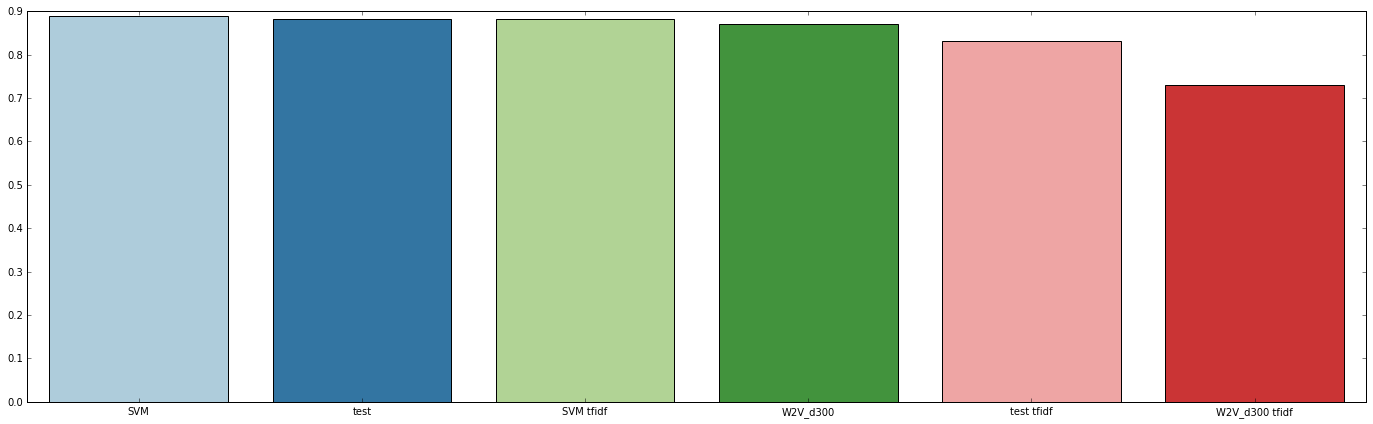

In [26]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

scores = sorted([(result, all_results[result]) 
                 for result in all_results], 
                key=lambda (_, x): -x)

print tabulate(scores, floatfmt=".4f", headers=("model", 'score'))
sns.set_palette(sns.color_palette("Paired", 6))
plt.figure(figsize=(24, 7))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

Realizar testes variando o tamanho do conjunto de treinamento

In [27]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [28]:
import pandas as pd
import collections
all_models = collections.OrderedDict(sorted(all_models.items()))
train_sizes = [30, 60, 120, 240, 480, 720, 960, 1200, 1440, 1920, 2160, 2400]
table = []
for name in all_models:
    model = all_models[name]
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


Plotar gráfico

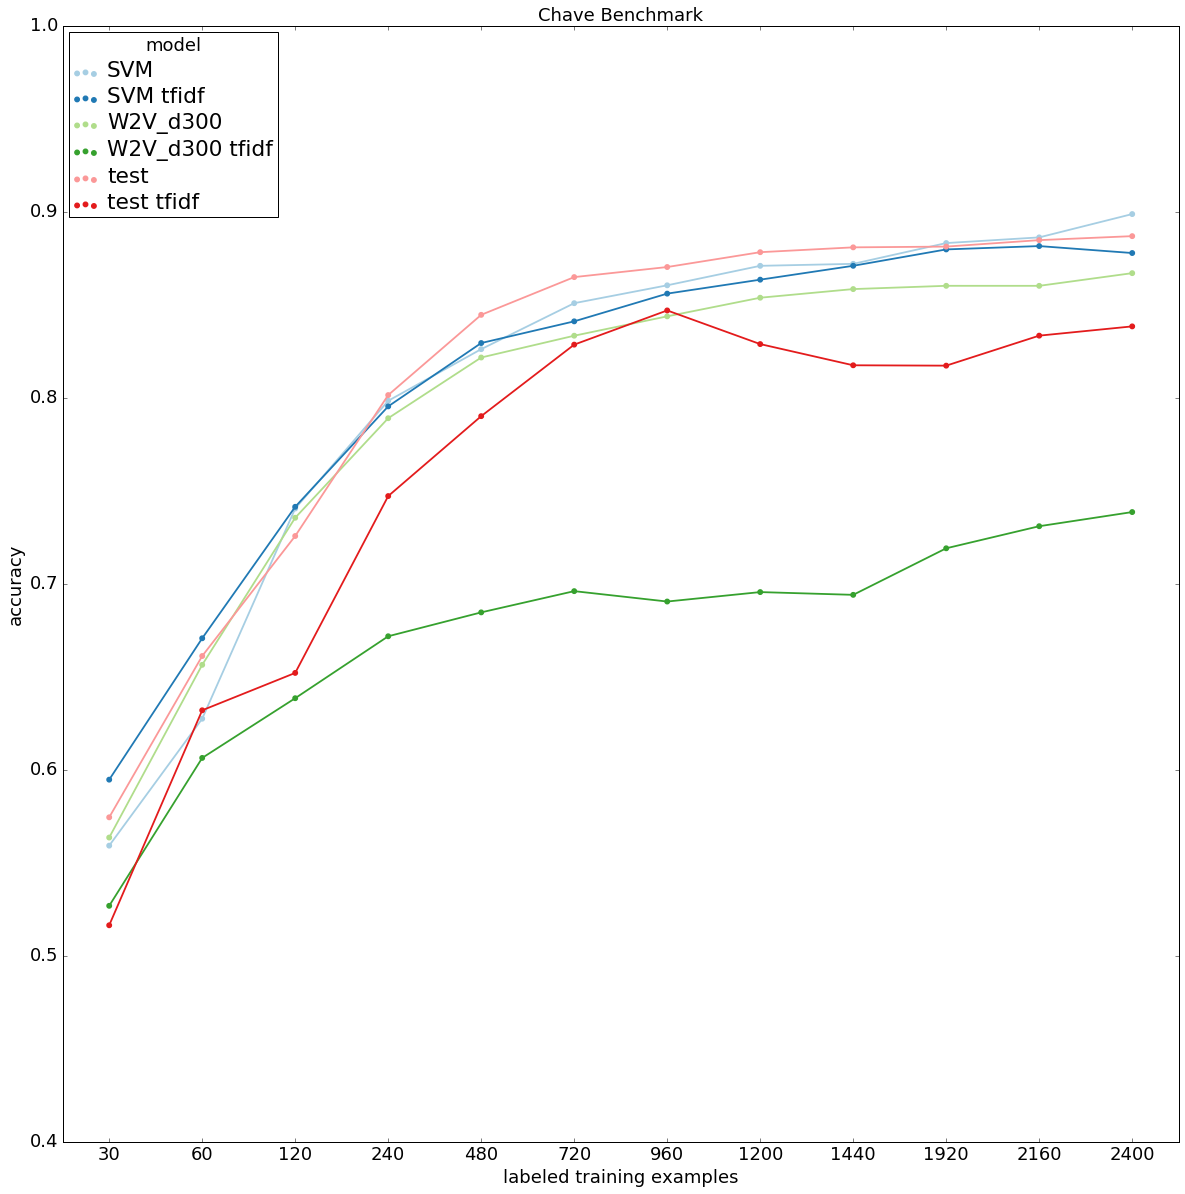

In [29]:
import seaborn as sns
plt.figure(figsize=(20, 20))
names = ['SVM', 'SVM tfidf', 'W2V_d300', 'W2V_d300 tfidf', 'test', 'test tfidf']
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in names)])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="Chave Benchmark")
fig.set(ylabel="accuracy")

In [30]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

sss = StratifiedShuffleSplit(y, n_iter=1, test_size=0.2, random_state=0)

scores2 = []
for model_name in all_models:
    model = all_models[model_name]
    measures = {'f1':[], 'precision':[], 'recall':[], 'accuracy':[]}
    for train_idx, test_idx in sss:
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        measures['f1'].append(f1_score(y_test, y_pred, average="macro"))
        measures['precision'].append(precision_score(y_test, y_pred, average="macro"))
        measures['recall'].append(recall_score(y_test, y_pred, average="macro"))
        measures['accuracy'].append(accuracy_score(y_test, y_pred))
    scores2.append((model_name, np.mean(measures['f1']), np.mean(measures['precision']), np.mean(measures['recall']), np.mean(measures['accuracy'])))
print tabulate(scores2, floatfmt=".4f", headers=("Model", 'F1 Score', 'Precision', 'Recall', 'Accuracy'))


Model             F1 Score    Precision    Recall    Accuracy
--------------  ----------  -----------  --------  ----------
SVM                 0.8862       0.8952    0.8825      0.8975
SVM tfidf           0.8834       0.8910    0.8794      0.8908
W2V_d300            0.8705       0.8743    0.8684      0.8807
W2V_d300 tfidf      0.7279       0.7287    0.7282      0.7378
test                0.8916       0.8935    0.8901      0.8975
test tfidf          0.8341       0.8361    0.8328      0.8420


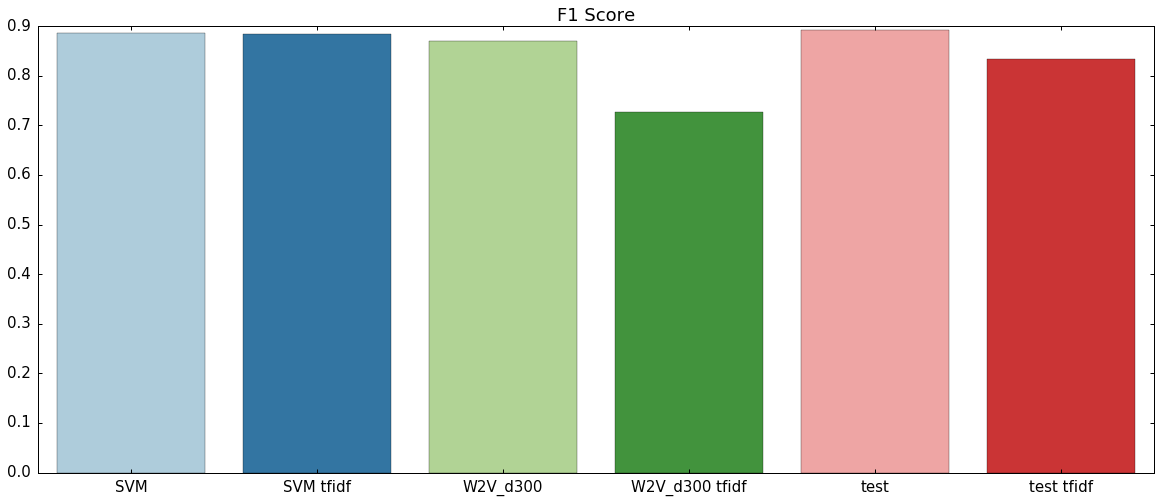

In [31]:
plt.figure(figsize=(20, 8))
plt.axes().set_title('F1 Score')
sns.barplot(x=[score[0] for score in scores2], y=[score[1] for score in scores2])

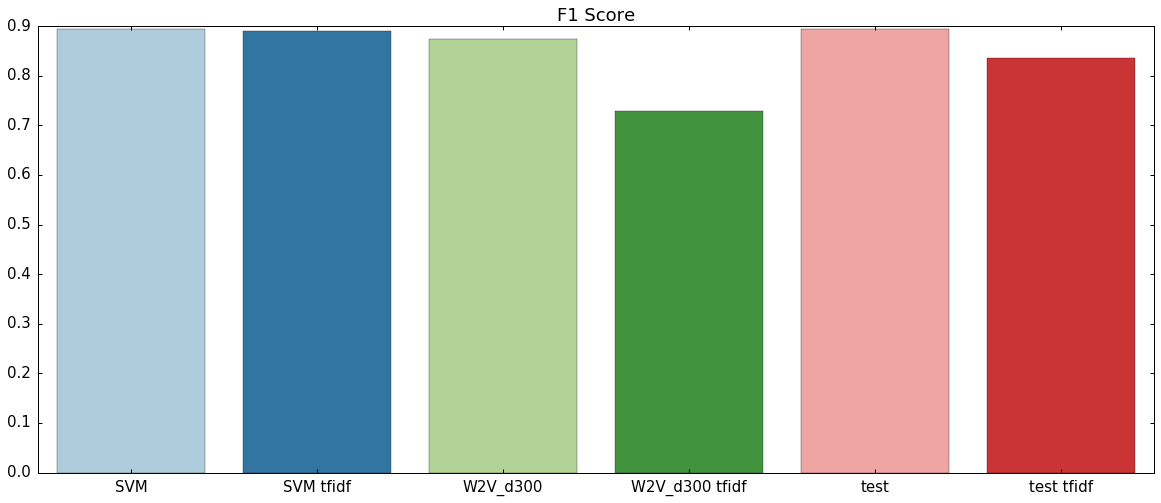

In [32]:
plt.figure(figsize=(20, 8))
plt.axes().set_title('F1 Score')
sns.barplot(x=[score[0] for score in scores2], y=[score[2] for score in scores2])

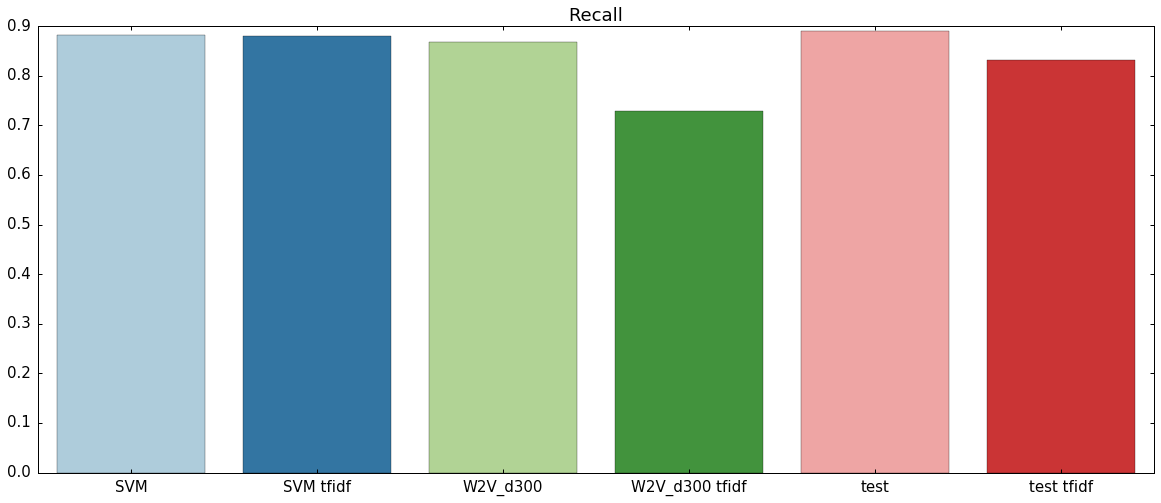

In [33]:
plt.figure(figsize=(20, 8))
plt.axes().set_title('Recall')
sns.barplot(x=[score[0] for score in scores2], y=[score[3] for score in scores2])

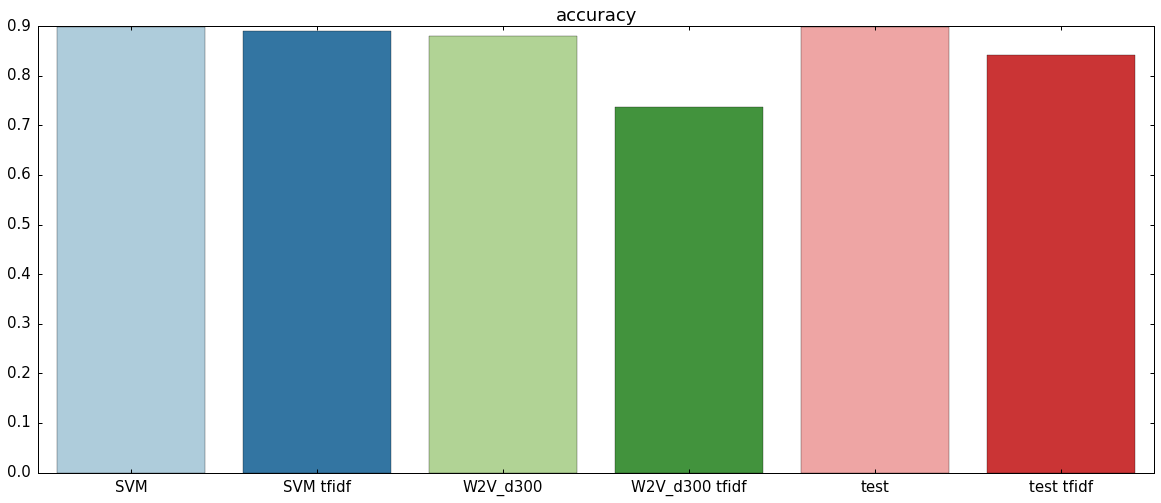

In [34]:
plt.figure(figsize=(20, 8))
plt.axes().set_title('accuracy')
sns.barplot(x=[score[0] for score in scores2], y=[score[4] for score in scores2])